<a href="https://colab.research.google.com/github/Nikkuchan/CpE-AIML/blob/main/58089_MEX_Padilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1

The dataset used is a customer personality analysis. Different variables concerning a customer are put down to determine if they are the ideal customers. The product, in this case wine, would be marketed specifically to the ideal customers. This is important as knowing your target is key. It may be that the company should adjust their products to a wider audience if the number of ideal customers is significantly low. It can also be used to determine just how much should the business produce in relation to the number of ideal customers. This helps a business's sales and production [1].

In [ ]:
import numpy as np
import pandas as pd
import datetime
from datetime import date
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv('marketing_campaign.csv',header=0,sep=';')

In [ ]:
from dataprep.eda import plot, plot_correlation, create_report, plot_missing
plot(data)

In [ ]:
#Spending variable creation
data['Age']=2014-data['Year_Birth']

data['Spending']=data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']
#Seniority variable creation
last_date = date(2014,10, 4)
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True,format = '%Y-%m-%d')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30
data=data.rename(columns={'NumWebPurchases': "Web",'NumCatalogPurchases':'Catalog','NumStorePurchases':'Store'})
data['Marital_Status']=data['Marital_Status'].replace({'Divorced':'Alone','Single':'Alone','Married':'In couple','Together':'In couple','Absurd':'Alone','Widow':'Alone','YOLO':'Alone'})
data['Education']=data['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Postgraduate','Master':'Postgraduate','PhD':'Postgraduate'})

data['Children']=data['Kidhome']+data['Teenhome']
data['Has_child'] = np.where(data.Children> 0, 'Has child', 'No child')
data['Children'].replace({3: "3 children",2:'2 children',1:'1 child',0:"No child"},inplace=True)
data=data.rename(columns={'MntWines': "Wines",'MntFruits':'Fruits','MntMeatProducts':'Meat','MntFishProducts':'Fish','MntSweetProducts':'Sweets','MntGoldProds':'Gold'})


data=data[['Age','Education','Marital_Status','Income','Spending','Seniority','Has_child','Children','Wines','Fruits','Meat','Fish','Sweets','Gold']]
data.head()

In [ ]:
data=data.dropna(subset=['Income'])
data=data[data['Income']<600000]

In [ ]:
scaler=StandardScaler()
dataset_temp=data[['Income','Seniority','Spending']]
X_std=scaler.fit_transform(dataset_temp)
X = normalize(X_std,norm='l2')

gmm=GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=5).fit(X)
labels = gmm.predict(X)
dataset_temp['Cluster'] = labels
dataset_temp=dataset_temp.replace({0:'Stars',1:'Need attention',2:'High potential',3:'Leaky bucket'})
data = data.merge(dataset_temp.Cluster, left_index=True, right_index=True)

pd.options.display.float_format = "{:.0f}".format
summary=data[['Income','Spending','Seniority','Cluster']]
summary.set_index("Cluster", inplace = True)
summary=summary.groupby('Cluster').describe().transpose()
summary.head()

In [ ]:
scaler=StandardScaler()
dataset_temp=data[['Income','Seniority','Spending']]
X_std=scaler.fit_transform(dataset_temp)
X = normalize(X_std,norm='l2')

gmm=GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=5).fit(X)
labels = gmm.predict(X)
dataset_temp['Cluster'] = labels
dataset_temp=dataset_temp.replace({0:'Stars',1:'Need attention',2:'High potential',3:'Leaky bucket'})
data = data.merge(dataset_temp.Cluster, left_index=True, right_index=True)

pd.options.display.float_format = "{:.0f}".format
summary=data[['Income','Spending','Seniority','Cluster']]
summary.set_index("Cluster", inplace = True)
summary=summary.groupby('Cluster').describe().transpose()
summary.head()

In [ ]:
#Create Age segment
cut_labels_Age = ['Young', 'Adult', 'Mature', 'Senior']
cut_bins = [0, 30, 45, 65, 120]
data['Age_group'] = pd.cut(data['Age'], bins=cut_bins, labels=cut_labels_Age)
#Create Income segment
cut_labels_Income = ['Low income', 'Low to medium income', 'Medium to high income', 'High income']
data['Income_group'] = pd.qcut(data['Income'], q=4, labels=cut_labels_Income)
#Create Seniority segment
cut_labels_Seniority = ['New customers', 'Discovering customers', 'Experienced customers', 'Old customers']
data['Seniority_group'] = pd.qcut(data['Seniority'], q=4, labels=cut_labels_Seniority)
data=data.drop(columns=['Age','Income','Seniority'])

In [ ]:
cut_labels = ['Low consumer', 'Frequent consumer', 'Biggest consumer']
data['Wines_segment'] = pd.qcut(data['Wines'][data['Wines']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Fruits_segment'] = pd.qcut(data['Fruits'][data['Fruits']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Meat_segment'] = pd.qcut(data['Meat'][data['Meat']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Fish_segment'] = pd.qcut(data['Fish'][data['Fish']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Sweets_segment'] = pd.qcut(data['Sweets'][data['Sweets']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data['Gold_segment'] = pd.qcut(data['Gold'][data['Gold']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data.replace(np.nan, "Non consumer",inplace=True)
data.drop(columns=['Spending','Wines','Fruits','Meat','Fish','Sweets','Gold'],inplace=True)
data = data.astype(object)

# Problem 2

### Apriori Algorithm

The Apriori algorithm is the most straightforward method for determining the underlying links between various categories of elements. This approach rests on the assumption that all nonempty subsets of a frequent category are also frequent [2]. It is a transactional database-based method for frequent item set mining and association rule learning. It works by recognizing the most common individual items in the database and expanding them to larger and larger item sets as long as those item sets exist in the database frequently enough. Apriori's frequent item sets can be used to create association rules that highlight general trends in the database, which can be useful in areas like market basket analysis [3].

### Mining Food Transactional Data To Produce Association Rules As A Basis Of Business Actions

This paper by F.Sulianta et. al. This concerns the food industry, which is more than a beverage, but also uses the apriori algorithm to map their customer's personality. They try to find out the taste of their customers instead of their likeliness to spend. The focus of this study was on how data was managed before the association rules were formed. The association rules were developed after three levels of validation on decreased high volumes of transactional data, and the rules established truth can be observed from the time series pattern on each group of items, which is then used as the basis of business operations. The association method is the apriori algorithm.

\begin{align}support(A \rightarrow B) = P(A \cup B)\end{align}

\begin{align}confidence(A \rightarrow B) = \frac{P(A \cup B)}{P(A)}\end{align}

The hypothesis of the paper is that the resulting confidence will be no less than 70% using FSA-Red reduction techniques and apriori method on number of transactional data.

The framework's scope begins with the separation of transactional data from the transaction processing system, which is then archived as a database file. The transformation is then completed by creating atomic data. The atomic data will be minimized, and an apriori method will be used to generate association rules during the mining stage.

The association rules were tested three times to determine the strength of the confidence. It did not disappoint. The reduction technique played a big part in obtaining a confidence no less than 70% if it's done before the apriori method [4].


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 999)
pd.options.display.float_format = "{:.3f}".format
association=data.copy() 
df = pd.get_dummies(association)
min_support = 0.08
max_len = 10
frequent_items = apriori(df, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

product='Wines'
segment='Biggest consumer'
target = '{\'%s_segment_%s\'}' %(product,segment)
results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
results_personnal_care.head()

# Problem 3

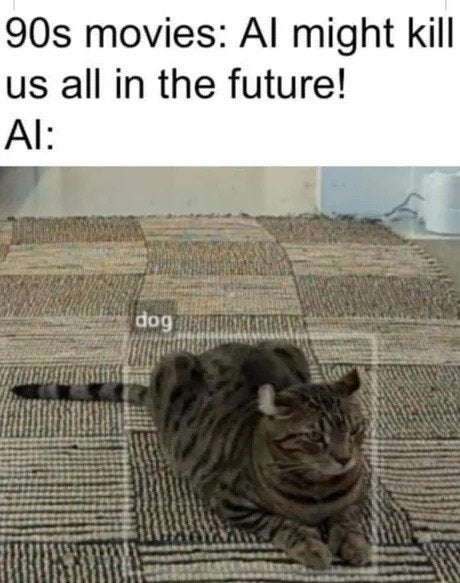

I have experienced this with the AI camera feature on my phone. My cat was on the screen and it was labeled as a dog. When I tried it on my other cats, they were labeled correctly. The lighting helped the feature to get the label right. The model used to train the AI camera feature might have not considered lighting. Still, as it got all my other cats correctly, the AI has a good accuracy. It may even be 98%, considering the scenario. There have been rare cases of 100% accuracy AIs and some of those are overfitted. While training the data and improving accuracy, these little blunders might happen and it sure does give a laugh. No, AI won't kill us all considering we haven't gotten to self-aware AIs yet, but any attempts so far went with self-destruction rather than world domination.  

###Reference

[1] A. Patel, "Customer Personality Analysis," Kaggle, [Online] Available: https://www.kaggle.com/imakash3011/customer-personality-analysis/version/1.

[2] "Apriori Algorithm," Geeks for Geeks, [Online]. Available: https://www.geeksforgeeks.org/apriori-algorithm/.

[3] "Apriori Algorithm," Semantic Scholar, [Online]. Available: https://www.semanticscholar.org/topic/Apriori-algorithm/74130.

[4] F. Sulianta, I. Ataina, et. al., "MINING FOOD TRANSACTIONAL DATA TO PRODUCE ASSOCIATION RULES AS A BASIS OF BUSINESS ACTIONS," Telkom University, 2013.